In [1]:
import pandas as pd 
from dk_model import DeepKrigingTrainer
from sklearn.linear_model import LinearRegression
import numpy as np
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from sklearn.model_selection import train_test_split
from pykrige.ok import OrdinaryKriging

In [6]:
deposit_data = pd.read_csv("Data/final_dataset_1_no_0.csv", low_memory=False)

# Deepkriging covariates

In [17]:
trainer_regular = DeepKrigingTrainer(deposit_data, covariates=['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm'], regular_nn=False, plot_errors=False)
trainer_regular.train_neural_network(mode="regular", test_size=0.1)
test_predictions_dk = trainer_regular.test_predictions

Deposit Data MSE: 0.0017, MAE: 0.0288, R2: 0.8951


# NN Covariates

In [18]:
trainer = DeepKrigingTrainer(deposit_data, covariates=['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm'], regular_nn=True, plot_errors=False)

trainer.train_neural_network(mode="regular", test_size=0.1)
test_predictions_nn = trainer.test_predictions

Deposit Data MSE: 0.0027, MAE: 0.0350, R2: 0.8330


# Reg kriging covariates

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import gstools as gs
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


y = deposit_data['Density_gcm3'].values  
x = deposit_data[['X', 'Y', 'Z', 'CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm']].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

reg_pred_train = regression_model.predict(x_train)
reg_pred_test = regression_model.predict(x_test)

residuals_train = y_train - reg_pred_train.flatten()

model = gs.Cubic(dim=3)
krige = gs.krige.Ordinary(model, cond_pos=[x_train[:, 0], x_train[:, 1], x_train[:, 2]], cond_val=residuals_train, fit_variogram=True)

kriging_pred, kriging_var = krige([x_test[:, 0], x_test[:, 1], x_test[:, 2]], return_var=True)

test_predictions_rk = reg_pred_test.flatten() + kriging_pred

mse = mean_squared_error(y_test, test_predictions_rk)
mae = mean_absolute_error(y_test, test_predictions_rk)

n = len(y_test)
sst = np.sum((y_test - np.mean(y_test)) ** 2)
ssr = np.sum((y_test - test_predictions_rk) ** 2)
r2 = 1 - (ssr / sst)

num_predictors = x_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))

# Calculate mean metrics across folds


print("Metrics for 3D kriging")
print(f"  Average MSE: {mse:.5f}")
print(f"  Average MAE: {mae:.5f}")
print(f"  Average adjusted R2: {adjusted_r2:.5f}")
print(f"  Average R2: {r2:.5f}")



Metrics for 3D kriging
  Average MSE: 0.00201
  Average MAE: 0.02814
  Average adjusted R2: 0.86985
  Average R2: 0.87384


In [10]:
filtered_unnormalised_deposit_data = pd.read_csv('Data/filtered_unnormalised_deposit_data.csv')
# Assuming filtered_unnormalised_deposit_data and deposit_data are defined
covariates=['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm']
# Calculate the multiplier for each column
multipliers = {}
for column in covariates + ['Density_gcm3']:
    ratio = deposit_data[column] / filtered_unnormalised_deposit_data[column]
    multiplier = ratio.mean()
    multipliers[column] = 1/multiplier

# Display the multipliers
multipliers_df = pd.DataFrame.from_dict(multipliers, orient='index', columns=['Multiplier'])
print(multipliers_df)


               Multiplier
CP_Total         4.000000
PO_Total        15.000000
PY_Total         5.000000
RQD_Pct        100.000000
Cr_ppm        1670.000000
Density_gcm3     7.223402


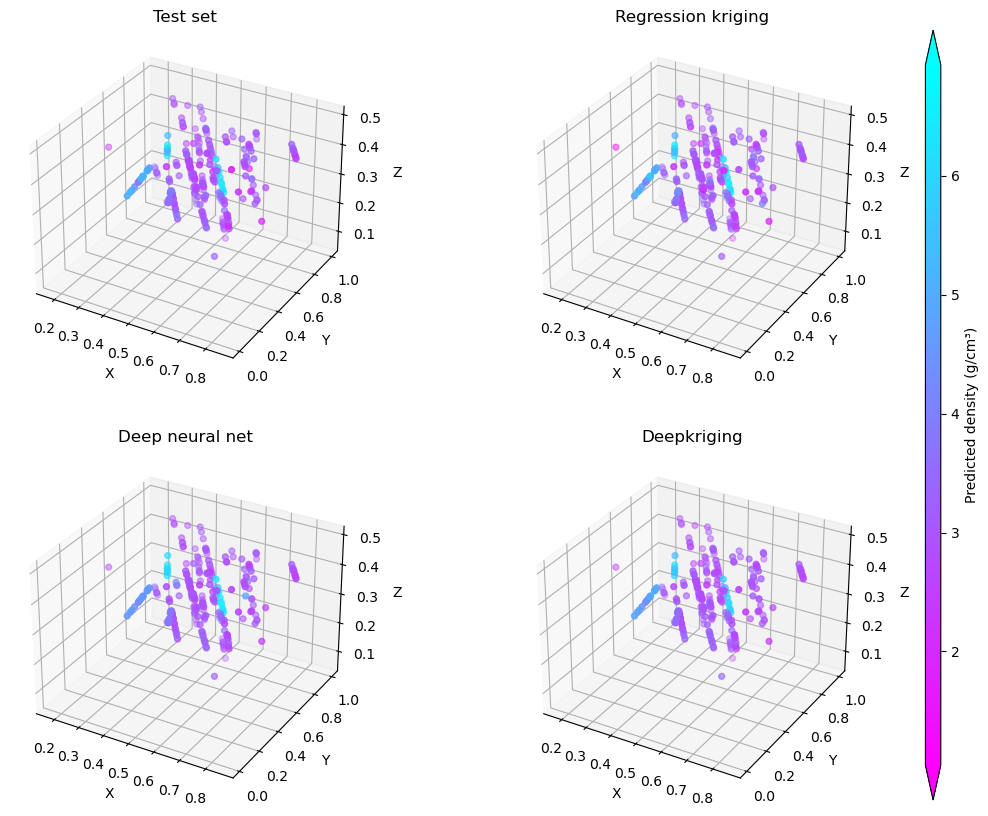

In [22]:
train_data_xyz = trainer.train_data[['X', 'Y', 'Z']].values
test_data_xyz = trainer.test_data[['X', 'Y', 'Z']].values

all_predictions = np.concatenate([test_predictions_dk.ravel(), test_predictions_nn.ravel(), test_predictions_rk.ravel(), y_test.ravel()])
min_value = all_predictions.min()*multipliers['Density_gcm3']
max_value = all_predictions.max()*multipliers['Density_gcm3']

# Define custom colormap using magenta and cyan colors, like the rest of the paper
colors = [(1, 0, 1), (0, 1, 1)] 
cmap_name = 'MagentaCyan'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

fig, axs = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={'projection': '3d'})

scatter1 = axs[1, 1].scatter(test_data_xyz[:, 0], test_data_xyz[:, 1], test_data_xyz[:, 2], c=test_predictions_dk.ravel()*multipliers['Density_gcm3'], cmap=custom_cmap, s=18, vmin=min_value, vmax=max_value)
scatter2 = axs[1, 0].scatter(test_data_xyz[:, 0], test_data_xyz[:, 1], test_data_xyz[:, 2], c=test_predictions_nn.ravel()*multipliers['Density_gcm3'], cmap=custom_cmap, s=18, vmin=min_value, vmax=max_value)
scatter3 = axs[0, 1].scatter(test_data_xyz[:, 0], test_data_xyz[:, 1], test_data_xyz[:, 2], c=test_predictions_rk.ravel()*multipliers['Density_gcm3'], cmap=custom_cmap, s=18, vmin=min_value, vmax=max_value)
scatter4 = axs[0, 0].scatter(test_data_xyz[:, 0], test_data_xyz[:, 1], test_data_xyz[:, 2], c=y_test.ravel()*multipliers['Density_gcm3'], cmap=custom_cmap, s=18, vmin=min_value, vmax=max_value)

axs[1, 1].set_title('Deepkriging')
axs[1, 0].set_title('Deep neural net')
axs[0, 1].set_title('Regression kriging')
axs[0, 0].set_title('Test set')

for ax in axs.flat:
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

# Create a single colorbar
norm = Normalize(vmin=min_value, vmax=max_value)
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])  
cbar = fig.colorbar(sm, ax=axs, pad=0.05, aspect=50, extend='both')
cbar.set_label('Predicted density (g/cm³)')

plt.savefig('Figures/3d_plots_all.png')  # Save the plot as PNG
plt.show()


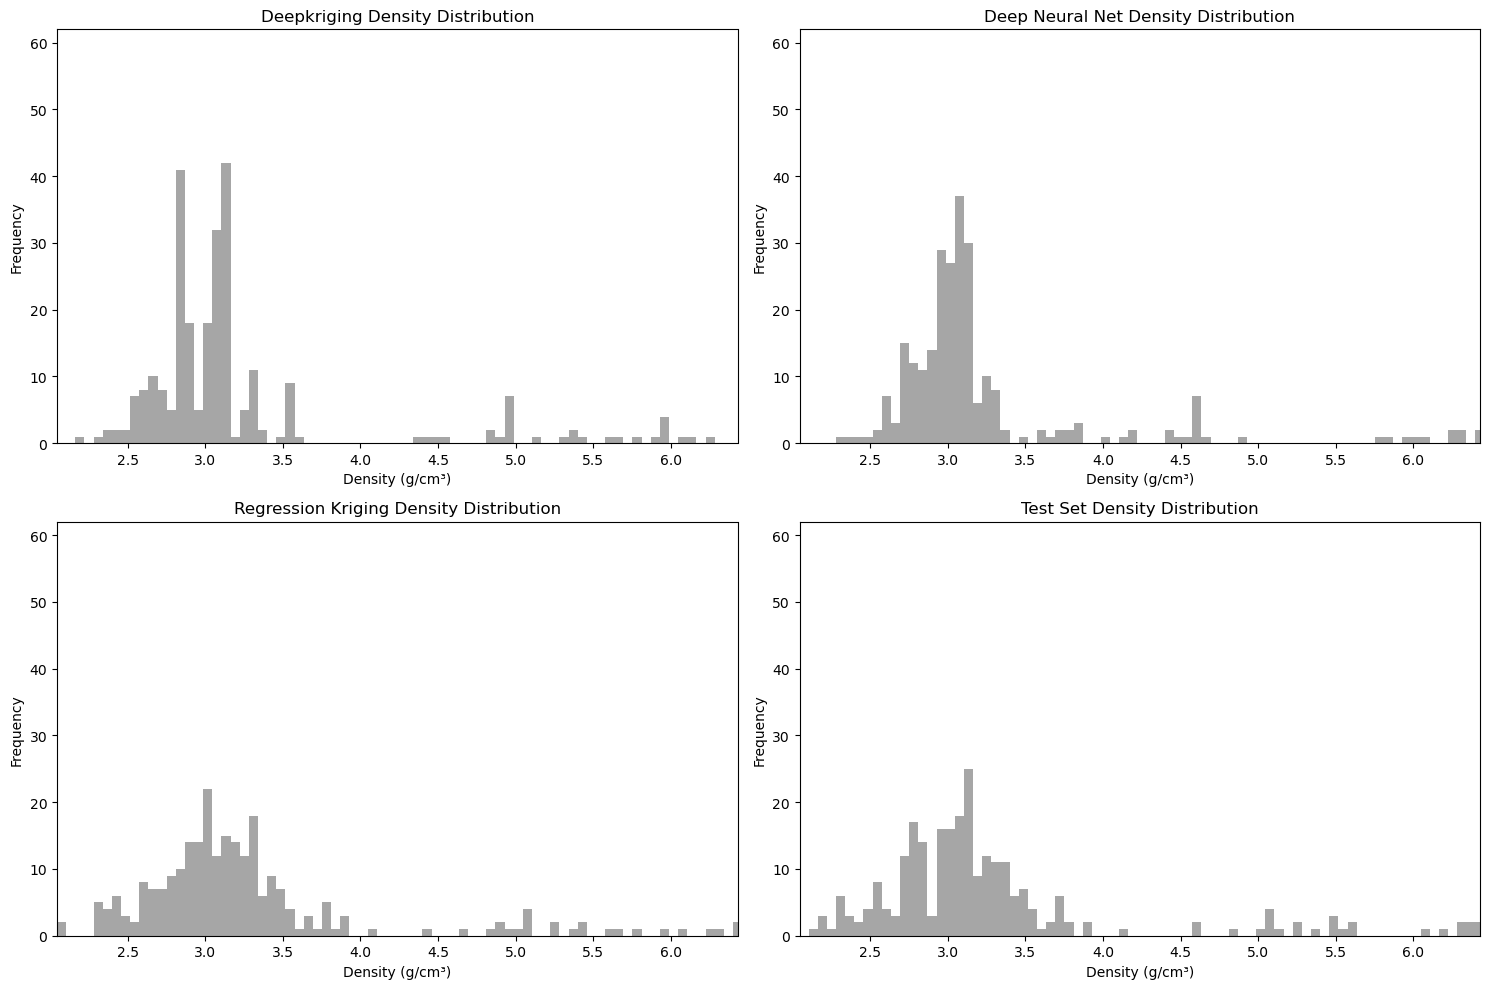

In [12]:
dk_density = test_predictions_dk.ravel() * multipliers['Density_gcm3']
nn_density = test_predictions_nn.ravel() * multipliers['Density_gcm3']
rk_density = test_predictions_rk.ravel() * multipliers['Density_gcm3']
test_density = y_test.ravel() * multipliers['Density_gcm3']

# Find global min and max for x-axis
all_densities = np.concatenate([dk_density, nn_density, rk_density, test_density])
x_min = all_densities.min() + 1
x_max = all_densities.max() - 0.5

# Find global max for y-axis by plotting histograms without displaying them
_, bins = np.histogram(all_densities, bins=100)
y_max = 0
for density in [dk_density, nn_density, rk_density, test_density]:
    counts, _ = np.histogram(density, bins=bins)
    y_max = max(y_max, counts.max()) + 5

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

#Deepkriging
axs[0, 0].hist(dk_density, bins=bins, color='gray', alpha=0.7)
axs[0, 0].set_title('Deepkriging Density Distribution')
axs[0, 0].set_xlim(x_min, x_max)
axs[0, 0].set_ylim(0, y_max)
axs[0, 0].set_xlabel('Density (g/cm³)')
axs[0, 0].set_ylabel('Frequency')

#Deep neural net
axs[0, 1].hist(nn_density, bins=bins, color='gray', alpha=0.7)
axs[0, 1].set_title('Deep Neural Net Density Distribution')
axs[0, 1].set_xlim(x_min, x_max)
axs[0, 1].set_ylim(0, y_max)
axs[0, 1].set_xlabel('Density (g/cm³)')
axs[0, 1].set_ylabel('Frequency')

#Regression kriging
axs[1, 0].hist(rk_density, bins=bins, color='gray', alpha=0.7)
axs[1, 0].set_title('Regression Kriging Density Distribution')
axs[1, 0].set_xlim(x_min, x_max)
axs[1, 0].set_ylim(0, y_max)
axs[1, 0].set_xlabel('Density (g/cm³)')
axs[1, 0].set_ylabel('Frequency')

#Test set
axs[1, 1].hist(test_density, bins=bins, color='gray', alpha=0.7)
axs[1, 1].set_title('Test Set Density Distribution')
axs[1, 1].set_xlim(x_min, x_max)
axs[1, 1].set_ylim(0, y_max)
axs[1, 1].set_xlabel('Density (g/cm³)')
axs[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()
